In [110]:
import numpy as np
from scipy.stats import gamma
from numpy.random import normal
from numpy.random import seed
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

In [111]:
%matplotlib notebook

In [112]:
lamb = 10 #The reciprocal of the Poisson rate
num_jolts = 20

In [113]:
rg = np.random.default_rng()
jt = rg.exponential(lamb, num_jolts) #The time points where the Gamma jolts start (but the initial one is at zero)

In [114]:
print(jt)

[ 0.86492248 17.49774317  0.82451775 14.32613472 17.62784571 13.17341563
  0.36438439  1.4451145   5.26449332 28.30730491 24.0036673   5.54091858
 21.60956456 12.34981869 11.35648372  3.40518239 28.29674724  0.74708885
 34.49250386  1.79126748]


In [115]:
L = 2 #length of the spring at equilibrium
mc = 10 #mass of car
mt = 1 #mass of tire
dc = 0.9 #damping constant for car
kc = 1 #spring constant for car and susupension
kt = 6 #spring constant for tire
n = 200 #number of evaluation points between jolts
Dt = 3 #tire diameter at eq 

In [116]:
class Slopy:
    
    def __init__(self, shape, rate, t_init, t_fini, state0, amp, freq):
        self.shape = shape
        self.rate = rate
        self.ti = t_init
        self.tf = t_fini
        self.s0 = state0
        self.amp = amp
        self.freq = freq
        
    def set_param(self, shape, rate, t_init, t_fini, state0):
        self.shape = shape
        self.rate = rate
        self.ti = t_init
        self.tf = t_fini
        self.s0 = state0

    def der_state(self, t, state):
        der = np.zeros_like(state)
        der[0] = state[1]
        der[1] = -(dc/mc)*state[1] + (dc/mc)*state[3] - (kc/mc)*state[0] + (kc/mc)*state[2] + gamma.pdf(t, self.shape, self.ti, self.rate)
        der[2] = state[3]
        der[3] = (dc/mt)*state[1] - (dc/mt)*state[3] - (kc/mt)*state[2] + (kc/mt)*state[0] - (kt/mt)*state[2] + (kt/mt)*self.amp*np.sin((t-self.ti)*self.freq) + gamma.pdf(t, self.shape, self.ti, self.rate)
        
        return der
    
    def solo(self):
        sol = integrate.solve_ivp(self.der_state, (self.ti, self.tf), self.s0, t_eval=T)
        return sol
    
    def forcer(self, t):
        jolt = gamma.pdf(t, self.shape, self.ti, self.rate)
        return jolt

In [117]:
state0 = ([0, 0, 0, 0]) 

In [118]:
seed(1)
amp_data = normal(0, 1, 500)
np.mean(amp_data)

0.053436894256306586

In [119]:
np.std(amp_data, ddof = 1)

0.9893981526296743

<IPython.core.display.Javascript object>


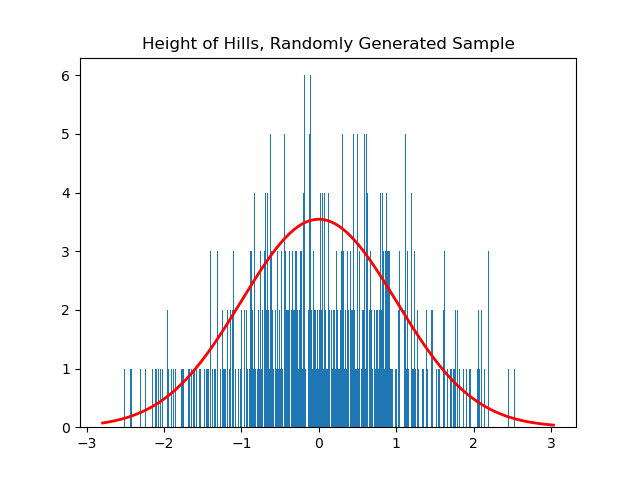

Text(0.5, 1.0, 'Height of Hills, Randomly Generated Sample')

In [120]:
count, bins, ignored = plt.hist(amp_data, 500)
plt.show()
plt.plot(bins, (2 * np.sqrt(1 * np.pi)) *np.exp( - (bins - 0)**2 / (2 * 1**2) ),linewidth=2, color='r')
plt.title('Height of Hills, Randomly Generated Sample')

In [121]:
for i in range(num_jolts):
    shape = rg.uniform(1, 6)
    rate = rg.uniform(0.2, 6)
    amp = rg.choice(amp_data)
    freq = 1/3
    if i == 0:
        ti = 0
        tf = jt[0]
        sloper = Slopy(shape,rate,ti,tf,state0, amp, freq)
    else:
        ti = tf
        tf = ti + jt[i]
        sloper.set_param(shape,rate,ti,tf,state0)
    dt = (tf-ti)/n
    T = np.linspace(ti, tf, n+1)
    
    sol = sloper.solo()
    state0 = [sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], sol.y[3][-1]]
    drive = sloper.forcer(T)
    
    if i == 0:
        position = sol.y[2]
        time_grid = sol.t
        force = drive
    else:
        position = np.concatenate((position, sol.y[2][1:]), axis=0)
        time_grid = np.concatenate((time_grid, sol.t[1:]), axis=0)
        force = np.concatenate((force, drive[1:]), axis=0)
   

In [122]:
print(shape)
print(rate)

2.441407252419497
3.4218497022025574


In [123]:
print('amplitude: ', amp)

amplitude:  0.0809271009732786


<IPython.core.display.Javascript object>


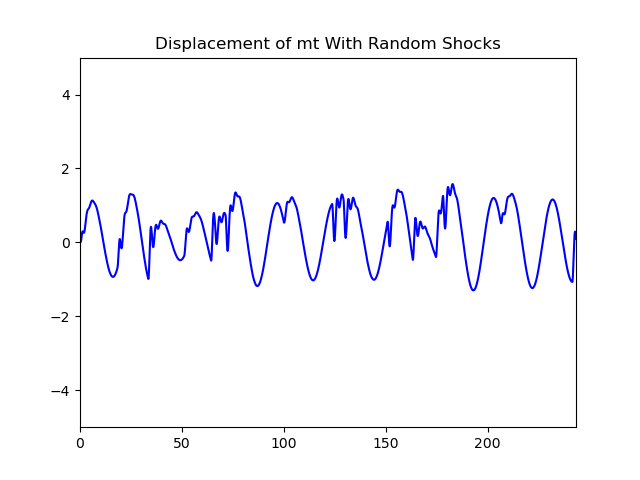

In [124]:
fig0 = plt.figure()
axi = fig0.add_subplot(111, xlim=(0, tf), ylim=(-5, 5))
plt.plot(time_grid, position, 'b')
plt.title('Displacement of mt With Random Shocks')
plt.show()

<IPython.core.display.Javascript object>


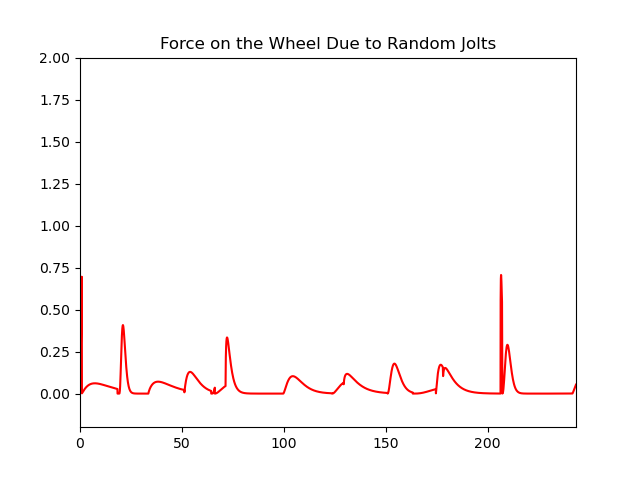

In [125]:
fig0 = plt.figure()
axi = fig0.add_subplot(111, xlim=(0, tf), ylim=(-0.2, 2))
plt.plot(time_grid, force, 'r')
plt.title('Shape of Gamma Function, Random Jolts')
plt.show()

In [126]:

f = interpolate.interp1d(time_grid, position, kind='cubic')
T_uni = np.linspace(time_grid[0], time_grid[-1], time_grid.size)
pos = f(T_uni)
udt = (time_grid[-1]-time_grid[0])/(time_grid.size-1)

In [127]:
time_grid[-1]

243.28911926066488

<IPython.core.display.Javascript object>


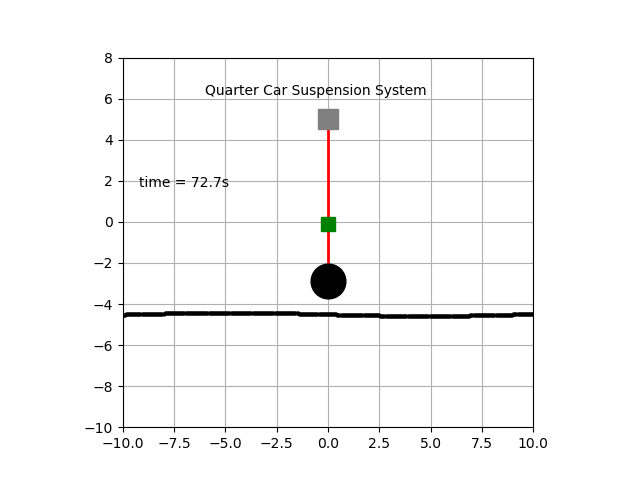

C:\Users\alexd\AppData\Local\Temp/ipykernel_7764/2934156283.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  wheel, = ax.plot([], [], 'bo',color = 'black', markersize = 25)


In [128]:
fig = plt.figure()
ax = fig.add_subplot(111,autoscale_on=False, xlim=(-10, 10), ylim=(-Dt-L-5, Dt+L+3))
ax.grid()
ax.set_aspect('equal', adjustable='box')

#Road profile
Xr = np.linspace(-10,500,10000)
Yr = amp*np.sin(Xr*freq)

# Initial conditions
lineC, = ax.plot([], [], color= 'r', lw=2) 
lineT, = ax.plot([], [], color= 'r', lw=2) 

massT, = ax.plot([], [],'gs', markersize = 10)
massC, = ax.plot([], [],'s', color = 'grey', markersize = 14)

wheel, = ax.plot([], [], 'bo',color = 'black', markersize = 25)

road, = ax.plot([], [], 'o', color='black', markersize = 2)


time_template = 'time = '
time_text = ax.text(0.04, 0.65, '', transform=ax.transAxes)

title = ax.text(0.2, 0.9, '', transform=ax.transAxes)
    
def init():
    lineC.set_data([], [])
    lineT.set_data([], [])
    
    massT.set_data([], [])
    massC.set_data([], [])
    
    wheel.set_data([], [])
    
    road.set_data([], [])
    
    time_text.set_text('')
    
    title.set_text('')
    
    return lineC, lineT, massT, massC, wheel, road, time_text, title


def animate(i):
    
    thisx = [0, 0] 
    thisyc = [0, pos[i]+5]
    thisyt = [0, -pos[i]-Dt]
   
    lineC.set_data(thisx, thisyc )
    
    lineT.set_data(thisx, thisyt)
    
    massC.set_data(0, L + Dt)
    massT.set_data(0, pos[i])
    
    wheel.set_data(0, -pos[i] - Dt)
    
    road.set_data(Xr[:i], -1.5*Dt - Yr[:i])
    
    time_text.set_text(time_template + '{:4.1f}'.format(i*udt) + 's')
    
    title.set_text("Quarter Car Suspension System")
    
    return lineC, lineT, mass1, mass2, wheel, road, time_text, title

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(T_uni)),
                              interval=20, blit=True, init_func=init)